In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from collections import Counter
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import os, gc
import cv2

pd.set_option('display.max_columns', None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Functions

In [2]:
def convert_pixels(data):
    """
    Convert pixels to the right intensity 0-1 and in a square matrix.
    """
    data = np.array([row.split(' ') for row in data['Image']],dtype='float') / 255.0
    data = data.reshape(-1,96,96,1)
    return(data)

In [3]:
def view_img(sample_img,coord=None):
    """
    Display an image. For debugging, display a coordinate on the image.
    input:
        - sample_img: numpy array. image to be displayed
        - coord: lst. of coordinates in form [[x_coordinate,y_coordinate],[x_coordinate,y_coordinate]]
    TODO handle multiple coordinates. Work out bugs with multiple coordinates
    """
    plt.figure()
    plt.imshow(sample_img.reshape(96,96),cmap='gray')
    if coord is not None:
        plt.scatter(coord[0],coord[1],marker = '*',c='r')
    plt.show()

In [4]:
def get_facial_keypoints(data,ind):
    """
    Structure the coordinates for all facial keypoints for a single image.
    inputs:
        - data: numpy array containing rows as each image sample and columns as facial keypoint coordinates
        - ind: index of the image
    output:
        - numpy array with format [[list of x-coordinates],[list of y-coordinates]]
    """
    data[ind]
    it = iter(data[ind])
    x_coord = []
    y_coord = []

    for x in it:
        x_coord.append(x)
        y_coord.append(next(it))
    
    return(np.array([x_coord,y_coord]))


## Import data

In [5]:
train_file = '../input/training/training.csv'
test_file = '../input/test/test.csv'
train_data = pd.read_csv(train_file)  
test_data = pd.read_csv(test_file)

print(f'Train set:{train_data.shape}, Test set:{test_data.shape}')

Train set:(7049, 31), Test set:(1783, 2)


In [6]:
# keep the relevant columns for the labels in the training data
y_train = train_data[[col for col in train_data.columns if col != 'Image']].to_numpy()
imputer = KNNImputer(n_neighbors=3, weights='distance')
y_train = imputer.fit_transform(y_train)
x_train = convert_pixels(train_data)

### Explore Bad Samples 

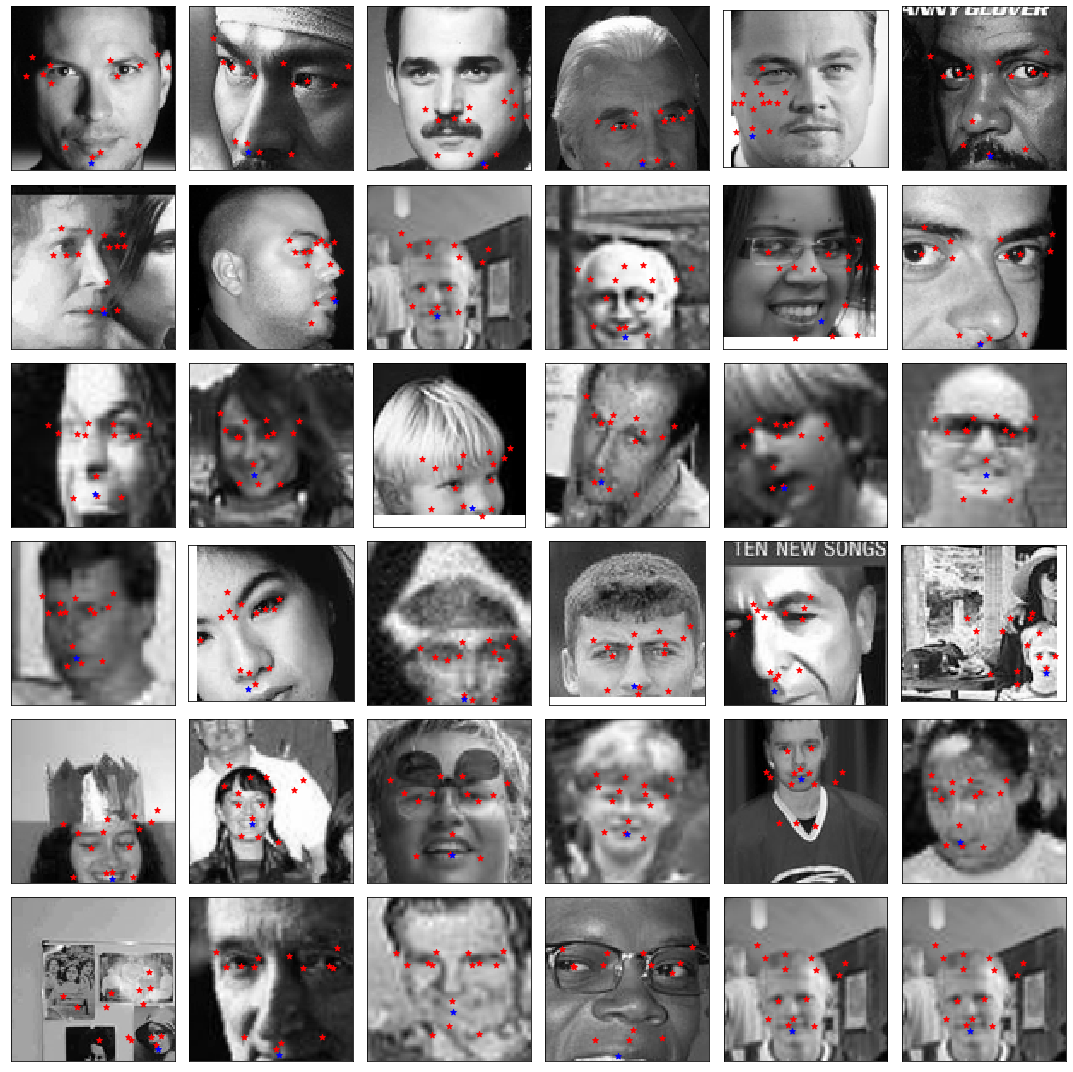

In [7]:
bad_samples = [1747, 1731, 1877, 1881, 1907, 1979, 2090, 2175, 2818, 2562, 2199, 2289, 2321, 2372, 2453, 2505, 2787, 
               2811,  3150, 3173, 3296, 3447, 4180, 4263, 4482,4490, 4636,5059, 5117,5952,6493,6585,6587,6859, 6906,6906]
               

def visualize_labels(samples):
    """
    Visualize bad labels.
    """
    num_rows = len(samples)//6
    fig, ax = plt.subplots(num_rows,6, figsize=(15, 5*(num_rows//2)) )
    ind = 0
    for i in range(num_rows):
        for j in range(6):
            
            coord0 = [y_train[samples[ind]][0:27:2], y_train[samples[ind]][1:28:2]]
            coord1 = [y_train[samples[ind]][28], y_train[samples[ind]][29]]
            ax[i,j].imshow(x_train[samples[ind]].reshape(96,96),cmap='gray')
            ax[i,j].scatter(coord0[0],coord0[1],marker = '*',c='r')
            ax[i,j].scatter(coord1[0],coord1[1],marker = '*',c='b')
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            ind = ind+1
    fig.tight_layout()        
    plt.show() 
visualize_labels(bad_samples) 

## EDA  
**train labels**
1. [x] Explore imputation strategies  
    - Completed code. Will require running entire model  
    - Perhaps take a look at images that have missing values to determine if there are inherent reasons why this is not valid.  
    - Create a summary slide of common reasons why things are not labeled.  
2. [ ] Explore outlier correction strategies to identify if areas of the face are mislabeled  
    - Identified several outlier images/labeling that we may be able to throw out of the training dataset
3. [ ] Label as -1,-1 to identify cutoff images  

**train image**  
1. [ ] Add noise via rotation, flipped image, blurring, etc. Ideally, not have to do any of these for capsule networks  
2. [x] Explore imputation strategies  
    - There are no missing pixels in the training or testing images.  
3. [ ] Add preprocessing for auto-contrast adjustment  

**test image**. 
1. [x] Review list of images in testing to see if poor quality images can be kept
    - Defined a list of images to definitely throw out

**overall**   
1. [x] Update to RMSE scoring  
2. [ ] Add code to troubleshoot the most wrongly predicted images to identify images causing large sources of error  

### Explore NA in labels
Based on the below analysis, distributions are fairly normal with some outliers, and mean and median are fairly similar.


Number of columns with any NA value:


True     28
False     3
dtype: int64


Number of images missing coordinates for each feature:


left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_bottom_lip_y      33
dtype: int64


Test skew of each distribution:


[('left_eye_center_x', 'Not normal'),
 ('left_eye_center_y', 'Not normal'),
 ('right_eye_center_x', 'Not normal'),
 ('right_eye_center_y', 'Not normal'),
 ('left_eye_inner_corner_x', 'Not normal'),
 ('left_eye_inner_corner_y', 'Not normal'),
 ('left_eye_outer_corner_x', 'Not normal'),
 ('left_eye_outer_corner_y', 'Not normal'),
 ('right_eye_inner_corner_x', 'Not normal'),
 ('right_eye_inner_corner_y', 'Not normal'),
 ('right_eye_outer_corner_x', 'Not normal'),
 ('right_eye_outer_corner_y', 'Not normal'),
 ('left_eyebrow_inner_end_x', 'Not normal'),
 ('left_eyebrow_inner_end_y', 'Not normal'),
 ('left_eyebrow_outer_end_x', 'Not normal'),
 ('left_eyebrow_outer_end_y', 'Not normal'),
 ('right_eyebrow_inner_end_x', 'Not normal'),
 ('right_eyebrow_inner_end_y', 'Not normal'),
 ('right_eyebrow_outer_end_x', 'Not normal'),
 ('right_eyebrow_outer_end_y', 'Not normal'),
 ('mouth_left_corner_x', 'Not normal'),
 ('mouth_left_corner_y', 'Not normal'),
 ('mouth_right_corner_x', 'Normal'),
 ('mouth_


Compare mean and median of these distribution:


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
mean,66.359021,37.651234,30.306102,37.976943,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,22.384504,38.033495,56.068513,29.332678,79.482826,29.734861,39.322137,29.502998,15.871177,30.428166,48.374186,62.715884,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,48.569472,78.970146
50%,66.497566,37.528055,30.251378,37.813273,59.304615,37.878040,73.247824,37.639015,36.651562,37.944075,22.535954,37.867071,56.244975,29.528872,79.784229,29.773813,39.298848,29.569347,15.785709,30.320160,48.424713,63.451421,63.178286,75.778689,32.982305,76.000592,47.905490,72.605173,48.594978,78.696326


(59.60048407784349, 73.11755841166332)

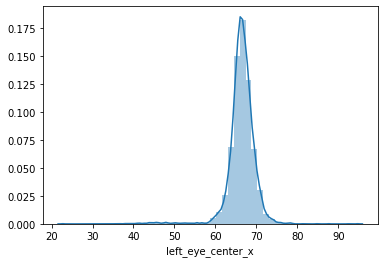

In [8]:
print('\nNumber of columns with any NA value:')
train_data.isnull().any().value_counts()
columns_nan = train_data.columns[train_data.isna().any()].tolist()

print('\nNumber of images missing coordinates for each feature:')
train_data[columns_nan].isna().sum(axis=0)

print('\nTest skew of each distribution:')
[(col,['Not normal' if stats.skewtest(train_data[col],nan_policy='omit').pvalue < .05 else 'Normal'][0]) for col in columns_nan]

print('\nCompare mean and median of these distribution:')
train_data.describe().loc[['mean','50%']]
sns.distplot(train_data[columns_nan[0]])
(train_data[columns_nan[0]].mean() - 1.96*train_data[columns_nan[0]].std(), train_data[columns_nan[0]].mean() + 1.96*train_data[columns_nan[0]].std())

Use Nearest Neighbors imputation. Takes closest 3 neighbors with the most important neighbor being the closest neighbor (`weights='distance' vs weights='uniform'`).

In [9]:
# imputer = KNNImputer(n_neighbors=3, weights='distance')
# y_train = imputer.fit_transform(y_train)

# y_train = y_train.fillna(y_train.mean())
# np.count_nonzero(~np.isnan(y_train))
# y_train = np.nan_to_num(y_train,nan=y_train.mean())


Compare imputed value with the actual image

In [10]:
def missing_coord(feature:str):
    """
    Compare missing labels for a specific feature with the imputed values.
    input:
        - feature: str. a facial keypoint we'd like to explore
    """
    print(f'\n========== Assessing missing feature: {feature} ==========')
    x_coord = feature + '_x'
    y_coord = feature + '_y'
    missing_feature = train_data.loc[(train_data[x_coord].isnull()) | (train_data[y_coord].isnull()),
                                 [x_coord,y_coord]]
    num_col = [ind for ind,el in 
               enumerate(train_data.columns.isin([x_coord,y_coord])) if el==True]

    for enum_ind,ind in enumerate(missing_feature.index):
        if enum_ind > 10: print('Too many images missing coordinates. Only printing 10.'); break
        impute_coord = y_train[ind][num_col]
        view_img(x_train[ind],impute_coord)
        print(f'Imputed {feature} coordinates for image {ind}:{impute_coord}\n')

# missing_coord('right_eye_center')
# missing_coord('left_eye_center')
# missing_coord('mouth_center_top_lip')
# missing_coord('left_eyebrow_outer_end')

### Explore NA in images
There are no missing pixels in the training or testing images.

In [11]:
img = [set(row.split(' ')) for row in train_data['Image']]
['' in row for row in img].count(True)

0

In [12]:
img = [set(row.split(' ')) for row in test_data['Image']]
['' in row for row in img].count(True)

0

### Explore outliers in labels

In [13]:
def detect_cutoff(feature:str):
    """
    DEPRECATED
    Compare outlier labels for a specific feature with the imputed values.
    input:
        - feature: str. a facial keypoint we'd like to explore
    """
    print(f'\n========== Assessing outlier feature: {feature} ==========')
    x_coord = feature + '_x'
    y_coord = feature + '_y'
    
    right_bound_y = train_data[y_coord].mean() + 3.5 * train_data[y_coord].std()
    left_bound_y  = train_data[y_coord].mean() - 3.5 * train_data[y_coord].std()    
    
    print(f'\ny coordinate confidence interval: {left_bound_y,right_bound_y}')
    
    outlier_feature = train_data.loc[(train_data[x_coord] <= left_bound_x) | (train_data[x_coord] >= right_bound_x) |
                                     (train_data[y_coord] <= left_bound_y) | (train_data[y_coord] >= right_bound_y),
                                 [x_coord,y_coord]]
    
    num_col = [ind for ind,el in 
               enumerate(train_data.columns.isin([x_coord,y_coord])) if el==True]

    for enum_ind,ind in enumerate(outlier_feature.index):
        if enum_ind > 10: print('Too many images have outlier coordinates. Only printing 10.'); break
        impute_coord = y_train[ind][num_col]
        view_img(x_train[ind],impute_coord)
        print(f'Imputed {feature} coordinates for image {ind}:{impute_coord}\n')


In [14]:
# find eyes that are situated lower than average
left_eye_upper_bound  = train_data['left_eye_center_y'].mean()  + 3 * train_data['left_eye_center_y'].std()
right_eye_upper_bound = train_data['right_eye_center_y'].mean() + 3 * train_data['right_eye_center_y'].std()
mouth_center_top_lip_upper_bound = train_data['mouth_center_top_lip_y'].mean() + 3 * train_data['mouth_center_top_lip_y'].std()

cutoff_faces = train_data[(train_data['left_eye_center_y'] >= left_eye_upper_bound)  |
                          (train_data['right_eye_center_y'] >= right_eye_upper_bound) |
                          (train_data['mouth_center_top_lip_y'] >= mouth_center_top_lip_upper_bound)]

    

Remove these indices from the training dataset:
- 1877
- 1907
- 2199
- 6493

In [15]:
# for ind in cutoff_faces.index:
#     print('Image Index:',ind)
#     view_img(x_train[ind],get_facial_keypoints(train_data[[col for col in train_data.columns if col != 'Image']].values,ind))
#     view_img(x_train[ind],get_facial_keypoints(y_train,ind))
    

In [16]:
# remove these indices that are poor labeling and poor image quality
mask = np.ones(x_train.shape[0],dtype=bool)
mask[[1877,1907,2199,6493]] = False
test = x_train[mask,:]

### Explore test images  
- Will need cartoons/drawings of faces
- Will need some cutoff images (missing bottom lip, etc.)
- Will need different ethnicities
- Will need blurred images
- Will need some images with dark lighting
- Will need some images with sun glasses

In [17]:
# # look at all images in the test set
# for ind in range(x_test.shape[0]):
#     view_img(x_test[ind])

### Explore preprocessing for data

#### Flip images horizontally

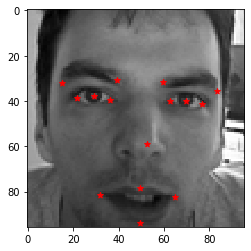

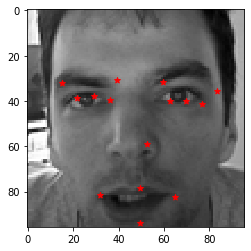

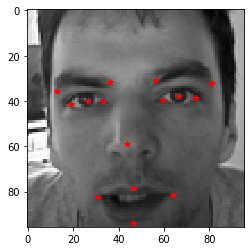

(7049, 96, 96, 1)

(7049, 30)

(7049, 96, 96, 1)

(7049, 30)

array([66.03356391, 39.00227368, 30.22700752, 36.4216782 , 59.58207519,
       39.64742256, 73.13034586, 39.96999699, 36.35657143, 37.3894015 ,
       23.45287218, 37.3894015 , 56.95326316, 29.03364812, 80.22712782,
       32.22813835, 40.22760902, 29.0023218 , 16.35637895, 29.64747068,
       44.42057143, 57.06680301, 61.19530827, 79.97016541, 28.61449624,
       77.38899248, 43.3126015 , 72.93545865, 43.13070677, 84.48577444])

array([29.96643609, 39.00227368, 65.77299248, 36.4216782 , 36.41792481,
       39.64742256, 22.86965414, 39.96999699, 59.64342857, 37.3894015 ,
       72.54712782, 37.3894015 , 39.04673684, 29.03364812, 15.77287218,
       32.22813835, 55.77239098, 29.0023218 , 79.64362105, 29.64747068,
       51.57942857, 57.06680301, 34.80469173, 79.97016541, 67.38550376,
       77.38899248, 52.6873985 , 72.93545865, 52.86929323, 84.48577444])

In [18]:
def flip_img_horiz():
    """
    Flip images horizontally for all training images
    """
    # Flip images
    flip_img = np.array([np.fliplr(x_train[[ind]][0]) for ind in range(x_train.shape[0])])
    
    # Flip coordinates
    x_columns = [col for col in train_data.columns if '_x' in col]
    train_data[x_columns] = train_data[x_columns].applymap(lambda x: 96-x)
    flip_coord = train_data[[col for col in train_data if col != 'Image']].to_numpy()
    return(flip_img,flip_coord)

flipped_img,flipped_coord = flip_img_horiz()

view_img(x_train[[5]],coord=get_facial_keypoints(y_train,5))
view_img(flipped_img[[5]],coord=get_facial_keypoints(y_train,5))
view_img(flipped_img[[5]],coord=get_facial_keypoints(flipped_coord,5))

# add to training array
x_train.shape
y_train.shape
# x_train = np.append(x_train,flipped_img,axis=0)
# y_train = np.append(y_train,flipped_coord,axis=0)
x_train.shape
y_train.shape

y_train[0]
flipped_coord[0]


#### Add blurring to the images

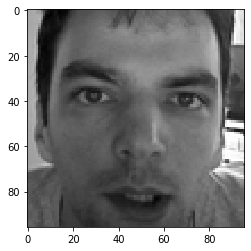

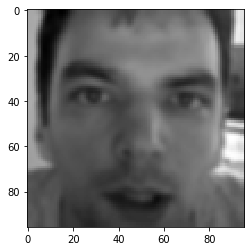

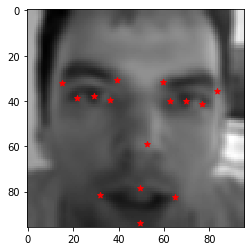

(7049, 96, 96, 1)

(7049, 96, 96, 1)

In [19]:
view_img(x_train[[5]])
view_img(cv2.GaussianBlur(x_train[[5]][0],(5,5),0))
view_img(cv2.GaussianBlur(x_train[[5]][0],(5,5),2),coord=get_facial_keypoints(y_train,5))

blurr_img = np.array([cv2.GaussianBlur(x_train[[ind]][0],(5,5),2).reshape(96,96,1) for ind in range(x_train.shape[0])])
blurr_img.shape
x_train.shape
# x_train = np.append(x_train,blurr_img)
# y_train = np.append(y_train,y_train,axis=0)

#### Add rotation to the face

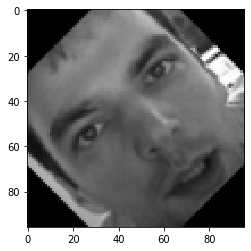

In [20]:
rows,cols = (96,96)

M = cv2.getRotationMatrix2D((cols/2,rows/2),45,1)
dst = cv2.warpAffine(x_train[[5]].reshape(96,96,1),M,(cols,rows))


view_img(dst)

#### Add translation to the images

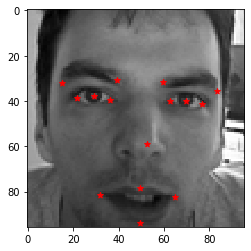

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


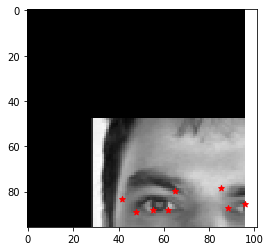

In [53]:
view_img(x_train[[5]],get_facial_keypoints(y_train,5))
rows,cols = (96,96)
shift_x = 96*.30
shift_y = 96*.50
M = np.float32([[1,0,shift_x],[0,1,shift_y]])
dst = cv2.warpAffine(x_train[[5]].reshape(96,96,1),M,(cols,rows))
# TODO move coordinates for y_train
x_col = [col for col in train_data.columns if (col != 'Image') & ('_x' in col)]
y_col = [col for col in train_data.columns if (col != 'Image') & ('_y' in col)]
trans_train_data = train_data.copy()
trans_train_data[x_col] += shift_x
trans_train_data[y_col] += shift_y
trans_train_data = np.array(trans_train_data[[col for col in trans_train_data.columns if col != 'Image']])
trans_train_data[trans_train_data >96]= np.nan

view_img(dst,get_facial_keypoints(trans_train_data,5))


#### Zoom in/out on images

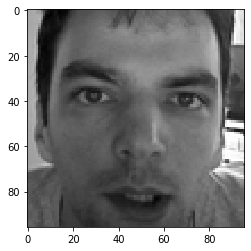

(1, 96, 96, 1)

ValueError: cannot reshape array of size 3249 into shape (96,96)

<Figure size 432x288 with 0 Axes>

In [43]:
img = x_train[[5]]
view_img(img)
scale_percent = 60 # percent of original size
width = int(96 * scale_percent / 100)
height = int(96 * scale_percent / 100)
dim = (width, height)
img.shape

# resize image
resized = cv2.resize(img[0], dim, interpolation = cv2.INTER_AREA)
# TODO move coordinates for y_train
view_img(resized,get_facial_keypoints(y_train,5))


### Missing value Imputation



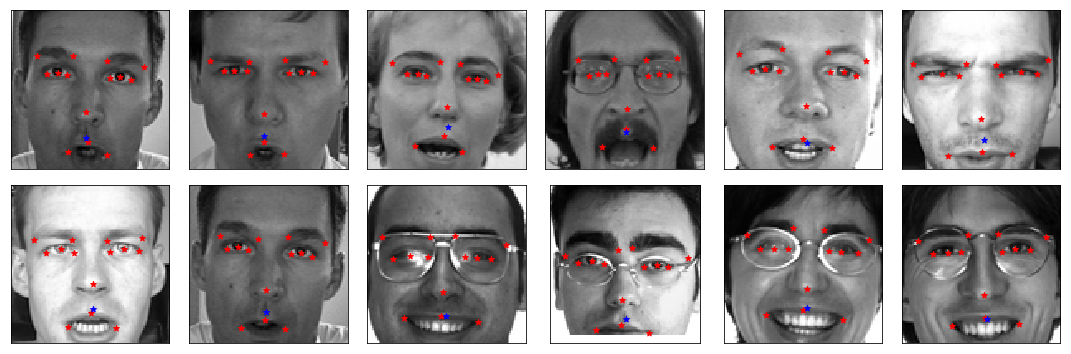

In [8]:
bad_bottom_lip = [210, 350, 499, 512, 810, 839, 895, 1058, 1194,1230, 1245, 1546, 1548]

visualize_labels(bad_bottom_lip)

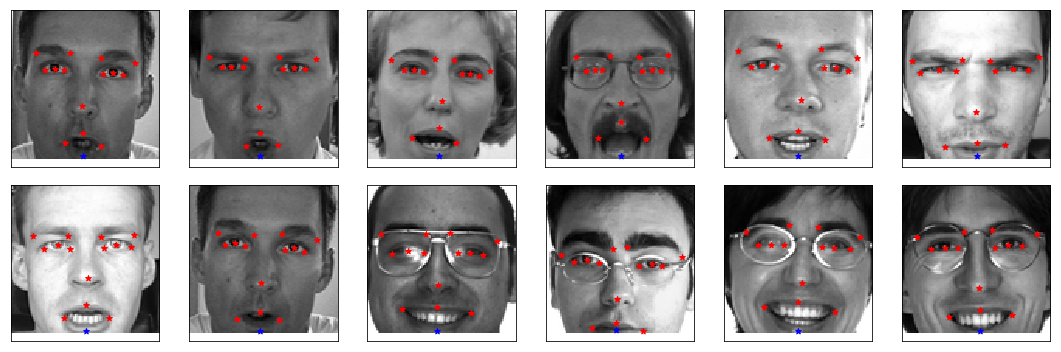

In [9]:
for sample in bad_bottom_lip:
    y_train[sample][29] = 94
    y_train[sample][28] = y_train[sample][26]
    
visualize_labels(bad_bottom_lip)    

#### Imputation with mean values

In [10]:
def fill_mouth_coord(y_train):
    
    count1, count2, count3 = 0,0,0
    MOUTH_BOTTOM = 29
    MOUTH_TOP = 27
    MOUTH_LEFT = 23
    MOUTH_RIGHT = 25
   
    for sample in range(len(y_train)):
        if(y_train[sample][MOUTH_TOP] > y_train[sample][MOUTH_BOTTOM]-2):
             y_train[sample][MOUTH_TOP] = y_train[sample][MOUTH_BOTTOM] -1
             count1 = count1+1   
   
        if((y_train[sample][MOUTH_LEFT] + y_train[sample][MOUTH_RIGHT]) > (2*y_train[sample][MOUTH_BOTTOM]-2)):
             diff = y_train[sample][MOUTH_LEFT] - y_train[sample][MOUTH_RIGHT]
            
             count2 = count2+1 
             if(diff > 0):
                y_train[sample][MOUTH_LEFT] = y_train[sample][MOUTH_BOTTOM] -1
                y_train[sample][MOUTH_RIGHT] = y_train[sample][MOUTH_BOTTOM] -1 - diff
           
             else:
                y_train[sample][MOUTH_LEFT] = y_train[sample][MOUTH_BOTTOM] -1 + diff
                y_train[sample][MOUTH_RIGHT] = y_train[sample][MOUTH_BOTTOM] -1
               
        if((y_train[sample][MOUTH_LEFT] + y_train[sample][MOUTH_RIGHT]) < (2*y_train[sample][MOUTH_TOP]+2)):    
           
             diff = y_train[sample][MOUTH_LEFT] - y_train[sample][MOUTH_RIGHT]
             count3 = count3+1 
       
             if(diff > 0):
                y_train[sample][MOUTH_LEFT] = y_train[sample][MOUTH_TOP] +1
                y_train[sample][MOUTH_RIGHT] = y_train[sample][MOUTH_TOP] +1 - diff
           
             else:
                y_train[sample][MOUTH_LEFT] = y_train[sample][MOUTH_TOP] +1 + diff
                y_train[sample][MOUTH_RIGHT] = y_train[sample][MOUTH_TOP] +1
                
                
    #print(count1, count2, count3)       
               
    return(y_train,[count1, count2, count3]) 

In [12]:
fill_na = True
y_train = train_data[[col for col in train_data.columns if col != 'Image']].to_numpy()
if fill_na:
    # https://stackoverflow.com/questions/18689235/numpy-array-replace-nan-values-with-average-of-columns
    # get column means
    col_mean = np.nanmean(y_train,axis=0)

    # find the x,y indices that are missing from y_train
    inds = np.where(np.isnan(y_train))

    # fill in missing values in y_train with the column means. "take" is much more efficient than fancy indexing
    y_train[inds] = np.take(col_mean, inds[1])
    
    y_impute = y_train.copy()
    y_impute, num_misalignments = fill_mouth_coord(y_impute)
    print(num_misalignments)

[1707, 2454, 2067]


### KNN Imputer

In [ ]:
knn_fill = True
if knn_fill:
    y_train = train_data[[col for col in train_data.columns if col != 'Image']].to_numpy()
    imputer = KNNImputer(n_neighbors=3, weights='distance')
    y_train = imputer.fit_transform(y_train)

    y_impute = y_train.copy()
    y_impute, num_misalignments = fill_mouth_coord(y_impute)
    print(num_misalignments)


### Iterative Imputer

In [ ]:
iter_fill = True
if iter_fill:
    y_train = train_data[[col for col in train_data.columns if col != 'Image']].to_numpy()
    imputer = IterativeImputer(max_iter=10000, tol=0.01, random_state=1, n_nearest_features=3)
    y_train = imputer.fit_transform(y_train)

    y_impute = y_train.copy()
    y_impute, num_misalignments = fill_mouth_coord(y_impute)
    print(num_misalignments)

### Visualization of fill_mouth_coord()

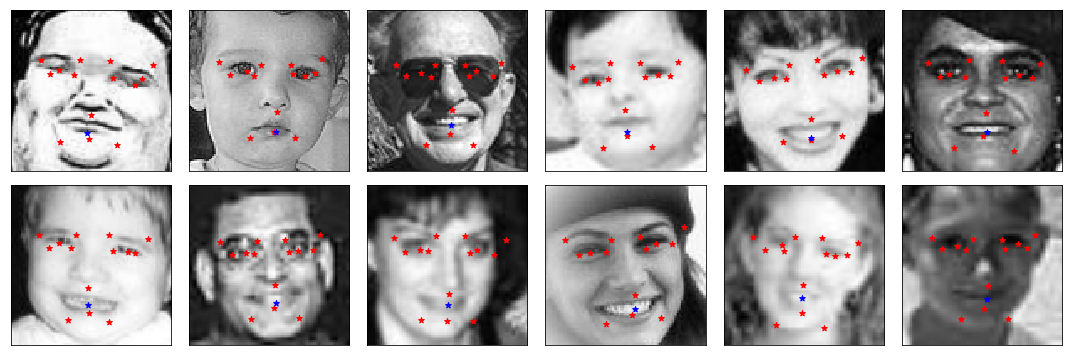

In [13]:
y_train = train_data[[col for col in train_data.columns if col != 'Image']].to_numpy()
imputer = KNNImputer(n_neighbors=3, weights='distance')
y_train = imputer.fit_transform(y_train)
fill_mouth_samples = [2912, 2937, 2959, 3075,4196, 4207, 4229, 4258, 4264,4268, 4272, 4276]
visualize_labels(fill_mouth_samples)


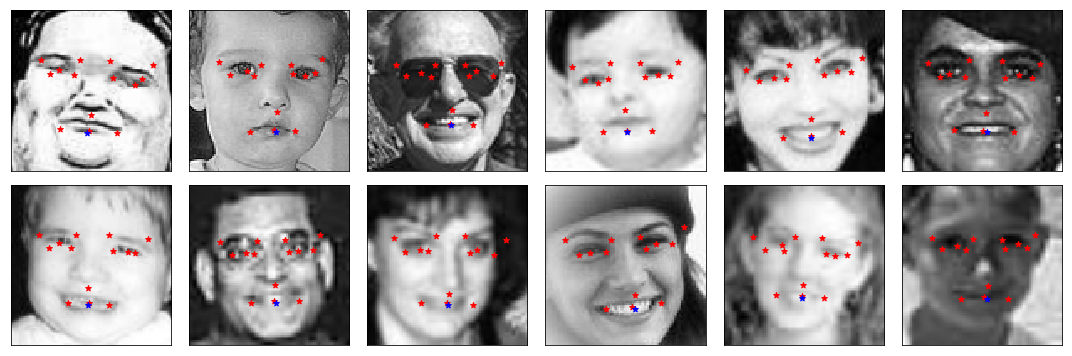

In [14]:
y_train, num_misalignments = fill_mouth_coord(y_train)
visualize_labels(fill_mouth_samples)